In [1]:
%matplotlib inline

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split  # if you are using scikit-learn >= 0.18 then use this:
#from sklearn.cross_validation import train_test_split  # for scikit-learn version <= 0.17
from sklearn.model_selection import GridSearchCV

The scikit-learn version is 0.18.1.


In [3]:
# Convert image to new color space (if specified)
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.    
def convert_color(image, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'H(LS)':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,1:]      
        elif cspace == 'H(L)S':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,1] 
            feature_image = feature_image[:,:,None]
        elif cspace == 'HL(S)':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)[:,:,2]    
            feature_image = feature_image[:,:,None]
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)            
    else: feature_image = np.copy(image)
       
    return feature_image

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [5]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    hist_features = np.histogram(img[:,:,0], bins=nbins, range=bins_range)[0]
    for i in range(1, img.shape[2]):
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((hist_features, np.histogram(img[:,:,i], bins=nbins, range=bins_range)[0]))

    # Return the feature vector
    return hist_features

In [6]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, ravel=True, feature_vector = True, transform_sqrt=True):
    hog_features = []
    for channel in range(img.shape[2]):
        features = hog(img[:,:,channel], orientations=orient, 
                              pixels_per_cell=(pix_per_cell, pix_per_cell),
                              cells_per_block=(cell_per_block, cell_per_block), 
                              transform_sqrt=transform_sqrt, 
                              visualise=False, feature_vector=feature_vector)
        hog_features.append( features )

    if ravel:
        hog_features = np.ravel(hog_features)    

    return hog_features  

In [7]:
# Define a function to return HOG features and visualization
def get_hog(img, orient, pix_per_cell, cell_per_block):
    features, hog_image = hog(img, orientations=orient, 
                              pixels_per_cell=(pix_per_cell, pix_per_cell),
                              cells_per_block=(cell_per_block, cell_per_block), 
                              transform_sqrt=True, 
                              visualise=True, feature_vector=True)
    return features, hog_image

In [8]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_color(img, cspace=color_space)
    
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        hog_features = get_hog_features(feature_image, orient, pix_per_cell, cell_per_block, transform_sqrt=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [9]:
# Define a function to extract features from a list of images using single_img_features
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        #image = mpimg.imread(file)
        image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
        
        file_features = single_img_features(image, color_space, spatial_size,
                        hist_bins, orient, 
                        pix_per_cell, cell_per_block, 
                        spatial_feat, hist_feat, hog_feat)
        
        features.append(file_features)
    # Return list of feature vectors
    return features

In [10]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [11]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [12]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows    

In [13]:
# Read in car and non-car images
cars = glob.glob('../images/vehicles_smallset/**/*.jpeg', recursive=True)
notcars = glob.glob('../images/non-vehicles_smallset/**/*.jpeg', recursive=True)
len(cars), len(notcars)

(1196, 1125)

In [14]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (8, 8) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
x_start_stop=[400, None]
y_start_stop = [400, 656] # Min and max in y to search in slide_window()

In [15]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

C:\Users\ETASMAK\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


In [16]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [17]:
# Split up data into randomized training and test sets
rand_state = 0 #np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split( scaled_X, y, test_size=0.2, random_state=rand_state)

In [18]:
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5580
0.34 Seconds to train SVC...
Test Accuracy of SVC =  1.0


C:\Users\ETASMAK\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


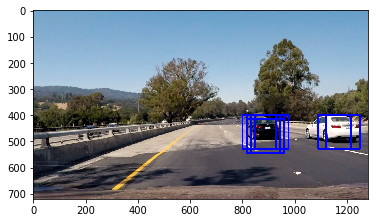

In [19]:
image = mpimg.imread('test_images/test4.jpg') #'bbox-example-image.jpg')
draw_image = np.copy(image)

windows = slide_window(image, x_start_stop, y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(56/64, 56/64))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)


In [20]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, color_space, svc, X_scaler, 
              x_start_stop=[None, None], y_start_stop=[None, None],
              scale=2, overlap=48/64, orient=9, pix_per_cell=8, cell_per_block=2,
              spatial_size=8, hist_bins=32,
              spatial_feat=True, hist_feat=True, hog_feat=True):

    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    img_tosearch = img[y_start_stop[0]:y_start_stop[1], x_start_stop[0]:x_start_stop[1], :]
    
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # Define blocks and steps as above
    nxblocks = (img_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (img_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    
    # Instead of overlap, define how many cells to step
    cells_per_step = np.int(window * (1 - overlap) / pix_per_cell)
    
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Convert to specified color space
    img_tosearch = convert_color(img_tosearch, cspace = color_space)

    if hog_feat:
        # Compute HOG features for the entire image
        hog_features_entire = get_hog_features(img_tosearch, orient, pix_per_cell, cell_per_block, ravel=False, feature_vector=False, transform_sqrt=True)
    
    # Create an empty list to receive positive detection windows
    hot_windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            #subimg = cv2.resize(color_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            subimg = img_tosearch[ytop:ytop+window, xleft:xleft+window]

            all_features = []
            
            # Get color features
            if spatial_feat:
                spatial_features = bin_spatial(subimg, size=spatial_size)
                all_features.append(spatial_features)
                
            if hist_feat:    
                hist_features = color_hist(subimg, nbins=hist_bins)
                all_features.append(hist_features)
 
            # Extract HOG for this patch
            if hog_feat:
                hog_features = []
                for i in range(img_tosearch.shape[2]):
                    hog_features.append(hog_features_entire[i][ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel())
                hog_features = np.hstack(tuple(hog_features))
                all_features.append(hog_features)

            #all_features = [spatial_features, hist_features, hog_features]    
                
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.array(np.concatenate(all_features)).reshape(1, -1))
             
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                
                hot_windows.append(((xbox_left + x_start_stop[0], ytop_draw + y_start_stop[0]),(xbox_left + win_draw + x_start_stop[0], ytop_draw+win_draw + y_start_stop[0])))
                
    return hot_windows

C:\Users\ETASMAK\AppData\Local\Continuum\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


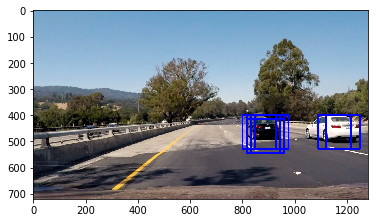

In [21]:
image = mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(image)

scale = 2
overlap=56/64

hot_windows = find_cars(image, color_space, svc, X_scaler,  x_start_stop, y_start_stop, scale,
                        overlap, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                        spatial_feat, hist_feat, hog_feat)
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

In [22]:
hot_windows

[((800, 400), (928, 528)),
 ((816, 400), (944, 528)),
 ((816, 416), (944, 544)),
 ((832, 400), (960, 528)),
 ((832, 416), (960, 544)),
 ((848, 400), (976, 528)),
 ((1088, 400), (1216, 528)),
 ((1120, 400), (1248, 528))]

In [23]:
from scipy.ndimage.measurements import label

def get_bboxes(hot_windows, prev_hot_windows=[], threshold=1, get_heatmap=True):
    
    # Take into account hot windows from a previous frame
    if len(prev_hot_windows)>0:
        hot_windows.append(prev_hot_windows) 
        threshold *= 2
    
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Iterate through list of bboxes
    for box in hot_windows:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        
     # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    bbox_list = []
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bbox_list.append(bbox)
    
    # Return bboxes and a heatmap
    if get_heatmap:
        # Visualize the heatmap when displaying    
        heatmap = np.clip(heatmap, 0, 255)    
        return bbox_list, heatmap
    else:
        return bbox_list

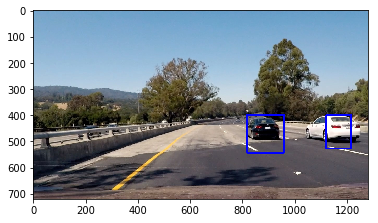

In [24]:
bboxes, heatmap = get_bboxes(hot_windows, threshold=1, get_heatmap=True)

window_img = draw_boxes(draw_image, bboxes, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

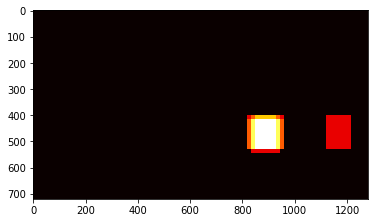

In [25]:
plt.imshow(heatmap, cmap='hot')